# Exploratory Data Analysis (EDA)

The goal of this notebook is to explore and 
understand the tabular property dataset used
for price prediction.  
We analyze target distribution, feature behavior, 
correlations, and data quality to motivate 
downstream modeling decisions.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pathlib import Path

DATA_DIR = Path("/Users/prabh/Desktop/ML/property_valuation/data")      # Adjust this path as per your local setup

PROCESSED_DIR = DATA_DIR / "processed"
IMAGES_DIR = DATA_DIR / "images"

print("Processed data path:", PROCESSED_DIR)
print("Images path:", IMAGES_DIR)

Processed data path: \Users\prabh\Desktop\ML\property_valuation\data\processed
Images path: \Users\prabh\Desktop\ML\property_valuation\data\images


In [4]:
train_df = pd.read_csv(PROCESSED_DIR / "train_processed.csv")
print(f"Number of samples: {len(train_df)}")
print(f"Number of features (including target): {train_df.shape[1]}")
train_df.head()

Number of samples: 12888
Number of features (including target): 21


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,...,condition,view,waterfront,yr_renovated,lat,long,yr_built,log_price,house_age,renovated_flag
0,9468200175,-0.389963,-0.147432,-0.456018,-0.296440,-0.922136,-0.954795,0.851994,-0.418122,-0.308374,...,-0.624011,-0.307569,-0.084792,4.780345,47.6789,-122.351,-1.099490,13.362169,1.099490,4.754408
1,4022905473,1.749602,1.161405,0.535074,-0.062849,-0.922136,-0.238882,1.560536,0.747606,0.160474,...,-0.624011,-0.307569,-0.084792,-0.210325,47.7657,-122.284,1.382221,13.244583,-1.382221,-0.210331
2,1623300765,-1.459745,-1.456269,-1.149782,-0.275396,-0.922136,-0.918392,-0.656515,-0.855271,-0.314025,...,-0.624011,-0.307569,-0.084792,-0.210325,47.6810,-122.361,-1.609431,13.058360,1.609431,-0.210331
3,826069085,-0.389963,0.179777,0.006492,0.949510,-0.922136,-0.238882,0.463439,0.412459,1.411546,...,-0.624011,-0.307569,-0.084792,-0.210325,47.7506,-122.063,0.260351,13.038984,-0.260351,-0.210331
4,9212900300,-1.459745,-1.456269,-1.237879,-0.233308,-0.922136,-1.015465,-0.656515,-0.796984,-0.248822,...,-0.624011,-0.307569,-0.084792,-0.210325,47.6897,-122.294,-0.997502,13.106236,0.997502,-0.210331


In [5]:
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

id_cols = ["id"]
target_col = ["log_price"]
geo_cols = ["lat", "long"]
size_features = [
    "sqft_living", "sqft_lot", "sqft_above",
    "sqft_basement", "sqft_living15", "sqft_lot15"
]

feature_cols = [
    c for c in numeric_cols
    if c not in id_cols + target_col + geo_cols
]

print("Number of numeric features:", len(feature_cols))

Number of numeric features: 17


**Note:**  
The dataset primarily consists of numeric,
preprocessed features along with geographic coordinates (`lat`, `long`) and the target variable (`log_price`).


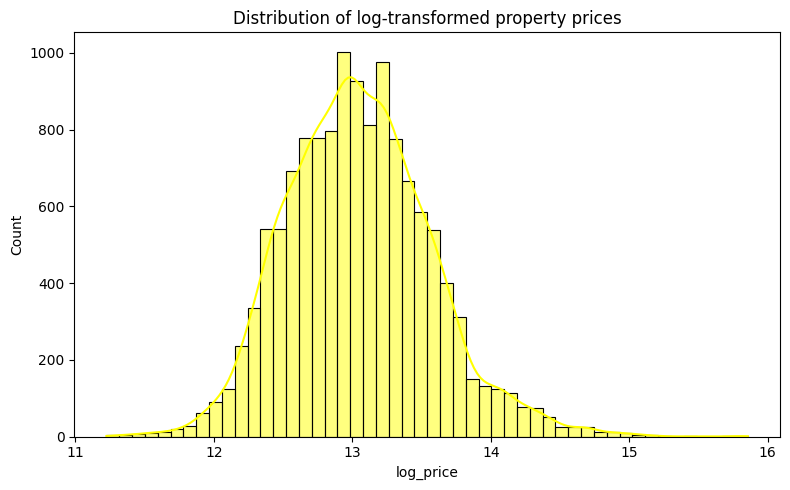

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df["log_price"], bins=50, kde=True, color = 'yellow')
plt.title("Distribution of log-transformed property prices")
plt.xlabel("log_price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


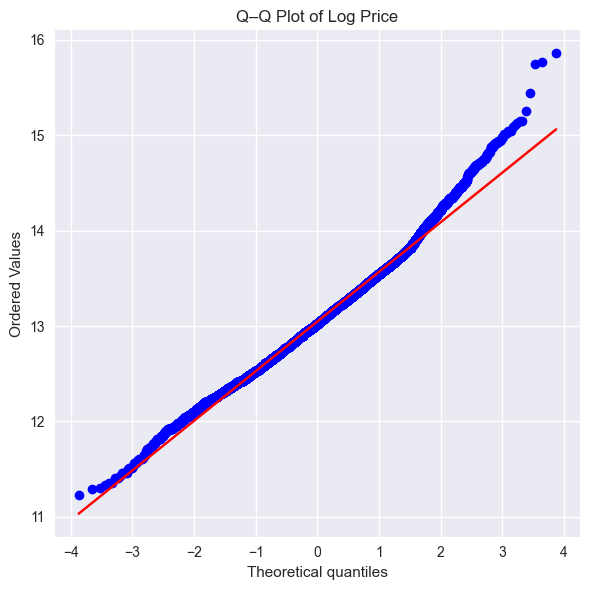

In [32]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(
    train_df["log_price"],
    dist="norm",
    plot=plt
)
plt.title("Q–Q Plot of Log Price")
plt.tight_layout()
plt.show()


The Q–Q plot shows approximate linearity in the central region, indicating that the log-transformed prices are reasonably well-approximated by a normal distribution. Deviations at the tails suggest the presence of extreme high- and low-valued properties, motivating the use of robust models rather than strict Gaussian assumptions.


In [21]:
train_df[feature_cols].describe().T[["mean", "std", "min", "max"]].head(10)

,mean,std,min,max
bedrooms,2.150153e-17,1.000039,-3.599309,31.703506
bathrooms,2.095020e-17,1.000039,-2.765105,7.705588
sqft_living,2.480945e-17,1.000039,-1.964680,10.985589
sqft_lot,2.922002e-17,1.000039,-0.377461,30.249123
floors,3.390625e-17,1.000039,-0.922136,3.674990
sqft_above,-1.598831e-17,1.000039,-1.816317,8.582624
sqft_basement,2.260417e-17,1.000039,-0.656515,7.343153
sqft_living15,1.819360e-17,1.000039,-2.313889,6.153673
sqft_lot15,2.232851e-17,1.000039,-0.442585,31.092276
grade,-8.104421e-17,1.000039,-5.657388,4.533976


**Observation:**  
Features vary significantly in scale, 
reinforcing the need for tree-based models (scale-invariant) 
and careful preprocessing for neural networks.


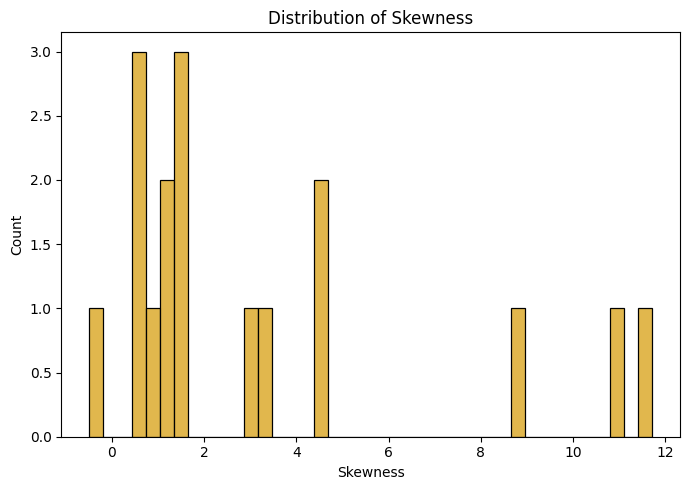

In [8]:
skewness = train_df[feature_cols].skew().sort_values(ascending=False)
plt.figure(figsize=(7, 5))
sns.histplot(
    skewness,
    bins=40,
    color="goldenrod",
    edgecolor="black",
    alpha=0.8
)
plt.xlabel("Skewness")
plt.ylabel("Count")
plt.title("Distribution of Skewness")
plt.tight_layout()
plt.show()


In [10]:
corr_with_target = (
    train_df[feature_cols + ["log_price"]]
    .corr()["log_price"]
    .drop("log_price")
    .sort_values(ascending=False)
)

corr_with_target.head(10)


grade            0.700739
sqft_living      0.693490
sqft_living15    0.617423
sqft_above       0.594845
bathrooms        0.550176
bedrooms         0.342639
view             0.337799
sqft_basement    0.318903
floors           0.300305
waterfront       0.148660
Name: log_price, dtype: float64

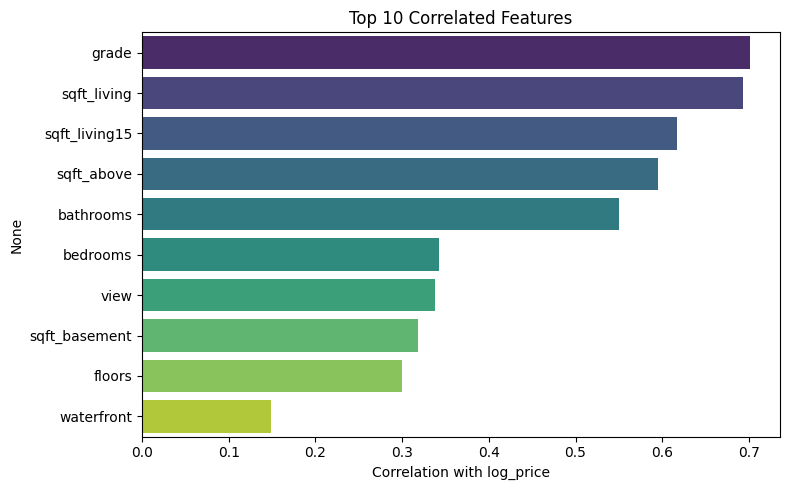

In [12]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=corr_with_target.head(10).values,
    y=corr_with_target.head(10).index,
    hue=corr_with_target.head(10).index,
    palette="viridis",
    legend=False
)
plt.xlabel("Correlation with log_price")
plt.title("Top 10 Correlated Features")
plt.tight_layout()
plt.show()


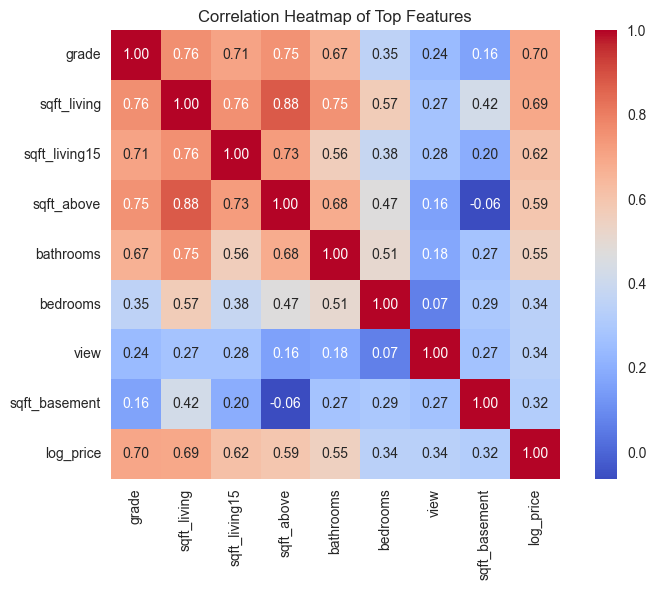

In [36]:
top_feats = corr_with_target.head(8).index.tolist()
heatmap_cols = top_feats + ["log_price"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    train_df[heatmap_cols].corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True
)
plt.title("Correlation Heatmap of Top Features")
plt.tight_layout()
plt.show()

**Observation:**
Some features are moderately correlated with each other, indicating potential multicollinearity.  
Tree-based models handle this well, while neural models benefit from learned representations.
Structural attributes such as living area, grade, and view show the strongest linear correlation with 
price. However, correlation strength alone does not capture non-linear interactions or 
neighborhood-level effects, motivating the use of more expressive models and additional contextual information.


In [15]:
train_df[["lat", "long"]].describe()

,lat,long
count,12888.000000,12888.000000
mean,47.560833,-122.213585
std,0.138483,0.139966
min,47.159300,-122.519000
25%,47.472775,-122.328000
50%,47.572250,-122.229000
75%,47.678200,-122.124000
max,47.777600,-121.316000


**Note:**  
Latitude and longitude exhibit meaningful ranges and will be analyzed in detail in the geospatial notebook to study spatial price patterns.


## EDA Summary

- The target variable (`log_price`) is well-distributed and approximately normal after log transformation.
- The dataset is clean, numeric, and free of missing values.
- Several tabular features show strong correlation with property prices, explaining the strong performance of tree-based models.
- Feature skewness and scale differences motivate robust preprocessing and non-linear models.
- Presence of geographic coordinates suggests spatial effects, motivating geospatial analysis and satellite image-based modeling.

This EDA establishes a strong foundation for the modeling and multimodal learning stages that follow.
